# Color transfert by regularized optimal transport
In this notebook, we show how to use `Sinkhorn.py` to resolve entropy-regularized optimal tranport and apply it to color transfert:
- Initialization of variables 
    - optimal transport: images, marginals, costs, parameters
    - Sinkhorn projection: kernel, parameters
- Computations
    - Sinkorn projection
    - optimal coupling
    - resulting images
- display the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sinkhorn import sinkhorn_debug, low_rank_Sinkhorn, sinkhorn
from builders import image2array, array2cost, image2array, transfer_color, array2image, array2matrix

## Initialization of variables:

In [2]:
N = 100 # heigth of the image (= width)
n = N^2 # number of pixels
eta = 15 # slow if more than ~20
delta = 1e-15 # tolerance for Sinkhorn()
img1_nbr = '3'
img2_nbr = '1'
img1 = image2array('img' + img1_nbr + '_' + str(N) + '.jpg') # source image
img2 = image2array('img' + img2_nbr + '_' + str(N) + '.jpg') # target image
C, p, q = array2cost(img1, img2) # cost and coupling marginals
Kmat = np.exp(-eta * C) # kernel to project 

def K(v):
    ''' Kernel-vector matrix product'''
    return Kmat @ v
def Kt(v):
    ''' Transposed_kernel-vector matrix product'''
    return (Kmat.T) @ v

## Sinkhorn projection computation:

In [3]:
u,v,W,err = sinkhorn(K,Kt,p,q,delta,maxtime=60)
P = u*Kmat*v.T # coupling

W = 564184927.5223013
Marginal error: 4.700558518810904e-16


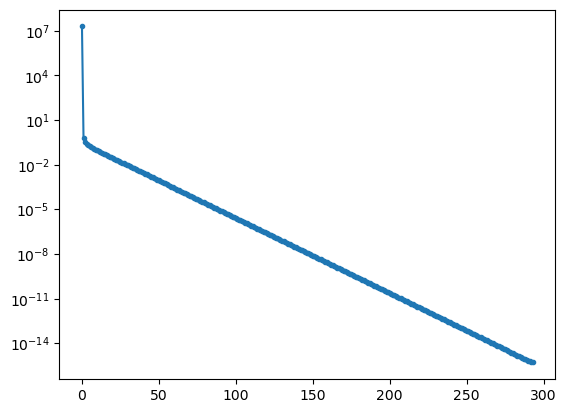

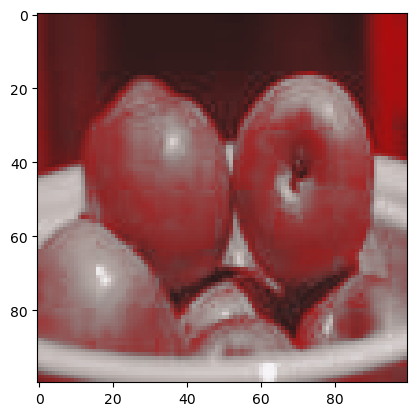

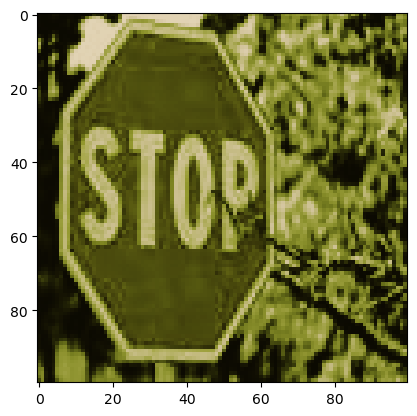

In [4]:
# Display
print("W =",W)
print("Marginal error:",err[-1])
plt.semilogy(err[:-1],".-")
# Compute resulting image
img12 = transfer_color(P,img1) # target image with source colors
img21 = transfer_color(P.T,img2) # symetry of problem
# show images:
plt.figure()
plt.imshow(array2matrix(img12),vmin=0, vmax=1)
plt.figure()
plt.imshow(array2matrix(img21),vmin=0, vmax=1)

In [5]:
# save in files
# array2image('img' + img1_nbr + img2_nbr + '.jpg', img12)
# array2image('img' + img2_nbr + img1_nbr + '.jpg', img21)

## Low rank approximation in Sinkhorn algorithm

### Defining our variables

In [3]:
#in this part, setting delta=10**(-10) and delta=10**(-15) was a value to small and 
#most algorithm-run converged between 10**(-11) and 10**(-15)
delta=10**(-10)

In [7]:
rank_K_mat=np.linalg.matrix_rank(Kmat, tol=None, hermitian=False)
print("rank of K:", rank_K_mat, "shape of K:", Kmat.shape)

405 (10000, 10000)


In [8]:
Kmat.shape

(10000, 10000)

In [4]:
# compute the speed of the algorithm depending on the approximation k, runs in 1011 seconds, no need to rerun, we have it 
#saved under csv
def running ():
    rank_K_mat=np.linalg.matrix_rank(Kmat, tol=None, hermitian=False)
    list_time_with_SVD=[]
    list_time_wtout_SVD=[]
    list_u=[]
    list_v=[]
    list_W=[]
    list_err_inf=[]
    [u,v,W,err] = sinkhorn(K,Kt,p,q,delta,maxtime=60)
    P_full= u*Kmat*v.T

    it=np.arange(25,rank_K_mat+70, 10) #adding 7 values above the rank of K_mat to study how things behave when, 
    #we're using a rank approximation higher than the rank of Kmat

    for k in it: 
        start_time=time.time()
        [low_u,low_v,W,err, P_low, end_time] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
        execution_time=time.time()-start_time
        list_time_with_SVD.append(execution_time)
        list_time_wtout_SVD.append(end_time)
        list_err_inf.append(np.linalg.norm(P_low-P_full,np.inf))
        list_u.append(low_u)
        list_v.append(low_v)
        list_W.append(W)
    return [list_u, list_v, list_W, list_time_with_SVD, list_time_wtout_SVD, list_err_inf, it]

In [5]:
import os 
import pandas

path_to_file='low_rank_sinkhorn.csv'

if (os.path.exists(path_to_file)):
    print('exists')
    df = pandas.read_csv('low_rank_sinkhorn.csv')
    list_u = df['list_u'].tolist()
    list_v = df['list_v'].tolist()
    list_W = df['list_W'].tolist()
    list_err_inf = df['list_err_inf'].tolist()
    list_time_wtout_SVD = df['time_wthout_SVD'].tolist()
    list_time_with_SVD = df['time_with_SVD'].tolist()
    it=df["rank"].tolist()
else: 
    print('no_exist')
    [list_u, list_v, list_W, list_time_with_SVD, list_time_wtout_SVD, list_err_inf, it]=running()
    dict = {'list_u': list_u, 'list_v': list_v, 'list_W': list_W, "time_with_SVD": list_time_with_SVD, 
        "time_wthout_SVD": list_time_wtout_SVD, "list_err_inf": list_err_inf, "rank": it}  
    df = pd.DataFrame(dict)
    # saving the dataframe 
    df.to_csv('low_rank_sinkhorn.csv')

exists


### Study how it impacts the solution

Text(0.5, 0, 'approximation rank')

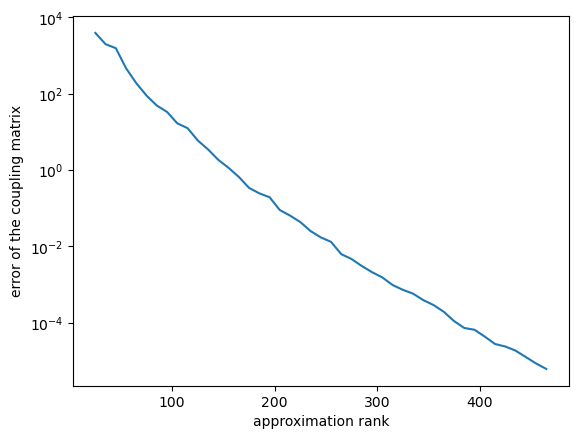

In [22]:
#how it impacts the error
plt.semilogy(it, list_err_inf)
plt.ylabel('error of the coupling matrix')
plt.xlabel('approximation rank')

Text(0.5, 0, 'approximation rank')

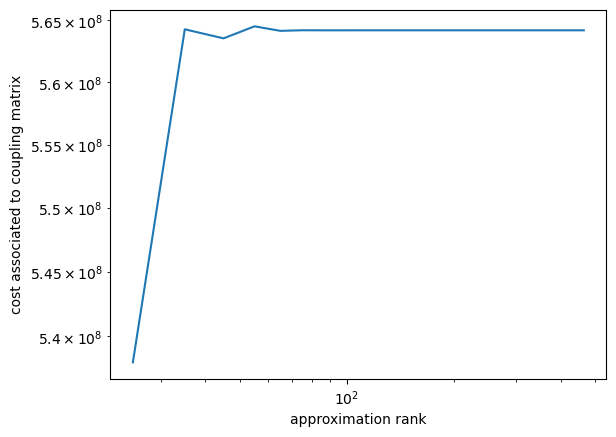

In [19]:
#how it impacts the cost
plt.loglog(it, list_W)
plt.ylabel('cost associated to coupling matrix')
plt.xlabel('approximation rank')

In [34]:
#ploting 10 images with different ranks

In [18]:
rank_images=np.arange(25,466,44) #for 465 to be included

In [38]:
#extracting the coupling corresponding to each low rank approximations
list_coupling=[]

for k in rank_images:
    [u,v,W,err, P, end_time] = low_rank_Sinkhorn(Kmat,k,p,q,delta,maxtime=60)
    list_coupling.append(P)

25
69
113
157
201
245
289
333
377
421
465


In [34]:
# Display
# Compute resulting image
def resulting_image(P, j):
    low_img12 = transfer_color(P,img1) # target image with source colors
    # show images:
    plt.figure()
    plt.imshow(array2matrix(low_img12),vmin=0, vmax=1)
    #array2image('img_rank' + j + '.jpg', img12)

1
2
3
4
5
6
7
8
9
10
11


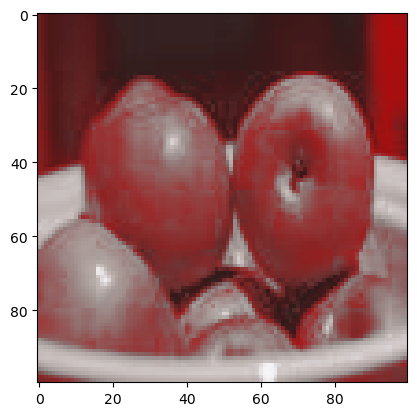

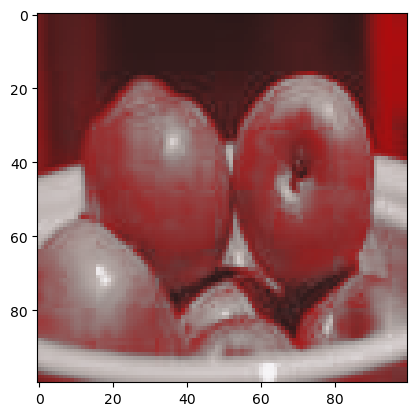

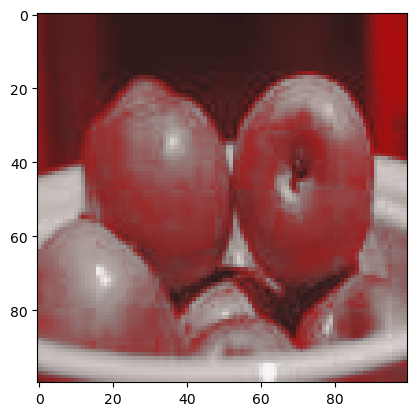

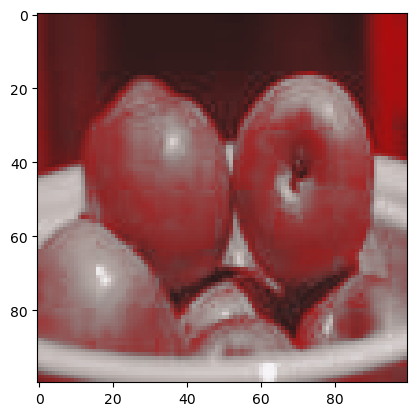

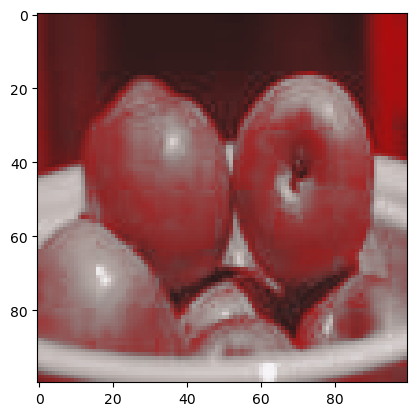

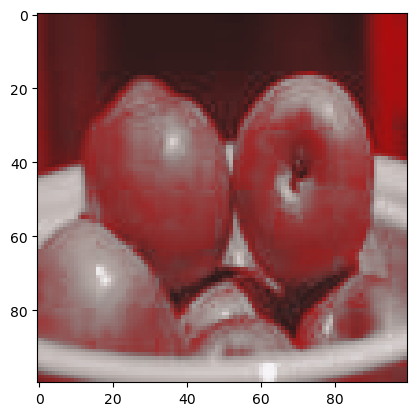

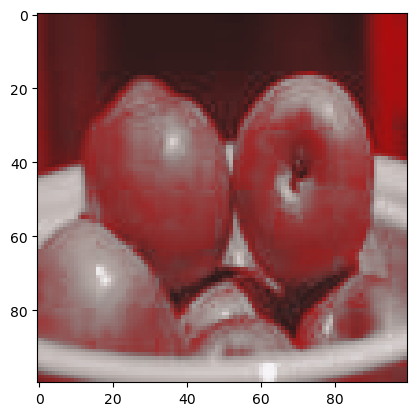

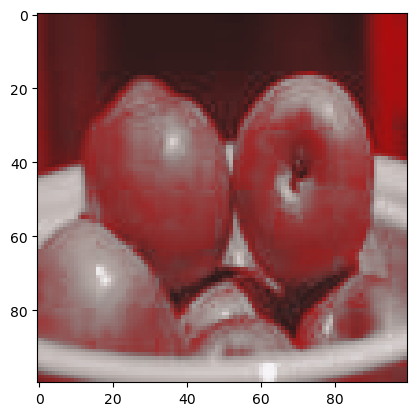

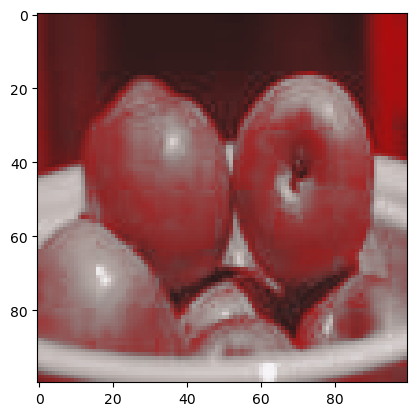

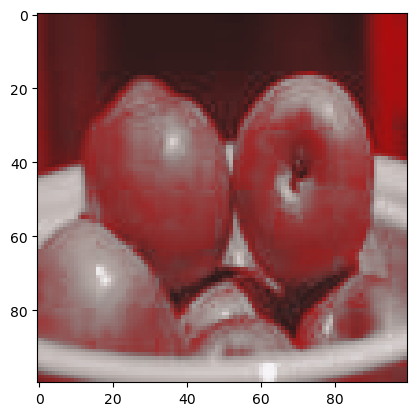

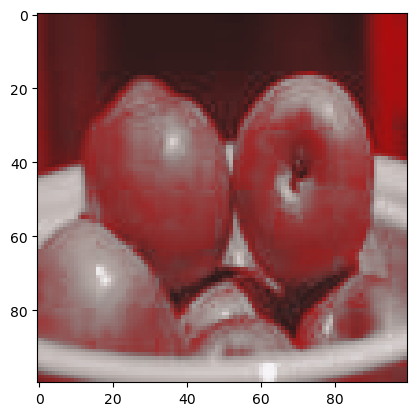

In [39]:
#displays 10 images resulting from color transfer with rank approximation the values in rank_images
rank_images_str= rank_images.astype(str)
i=0
for P in list_coupling:
    resulting_image(P,rank_images_str[i])
    i+=1

### Study how it impacts the computation time

In [20]:
Start=time.time()
sinkhorn(K,Kt,p,q,delta,maxtime=60)
execution=time.time()-Start
execution_list=[execution]*len(it)

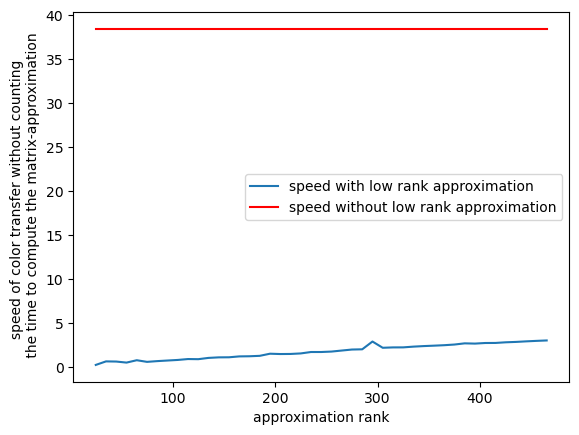

In [33]:
plt.plot(it, list_time_wtout_SVD)
plt.plot(it, execution_list, color='r')
plt.ylabel('speed of color transfer without counting \n the time to compute the matrix-approximation')
plt.xlabel('approximation rank')
plt.legend(labels=['speed with low rank approximation', 'speed without low rank approximation'])

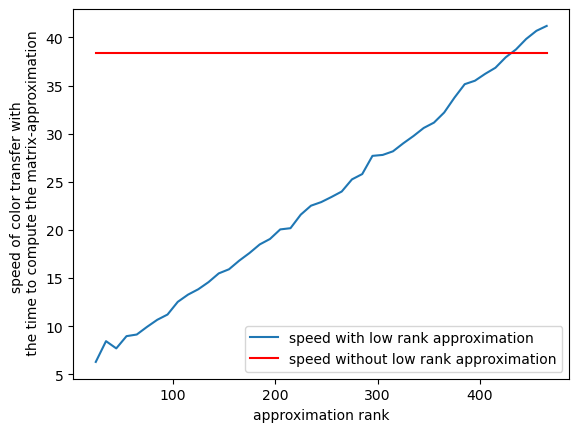

In [32]:
plt.plot(it, list_time_with_SVD)
plt.plot(it, execution_list, color='r')
plt.ylabel('speed of color transfer with \n the time to compute the matrix-approximation')
plt.xlabel('approximation rank')
plt.legend(labels=['speed with low rank approximation', 'speed without low rank approximation'])